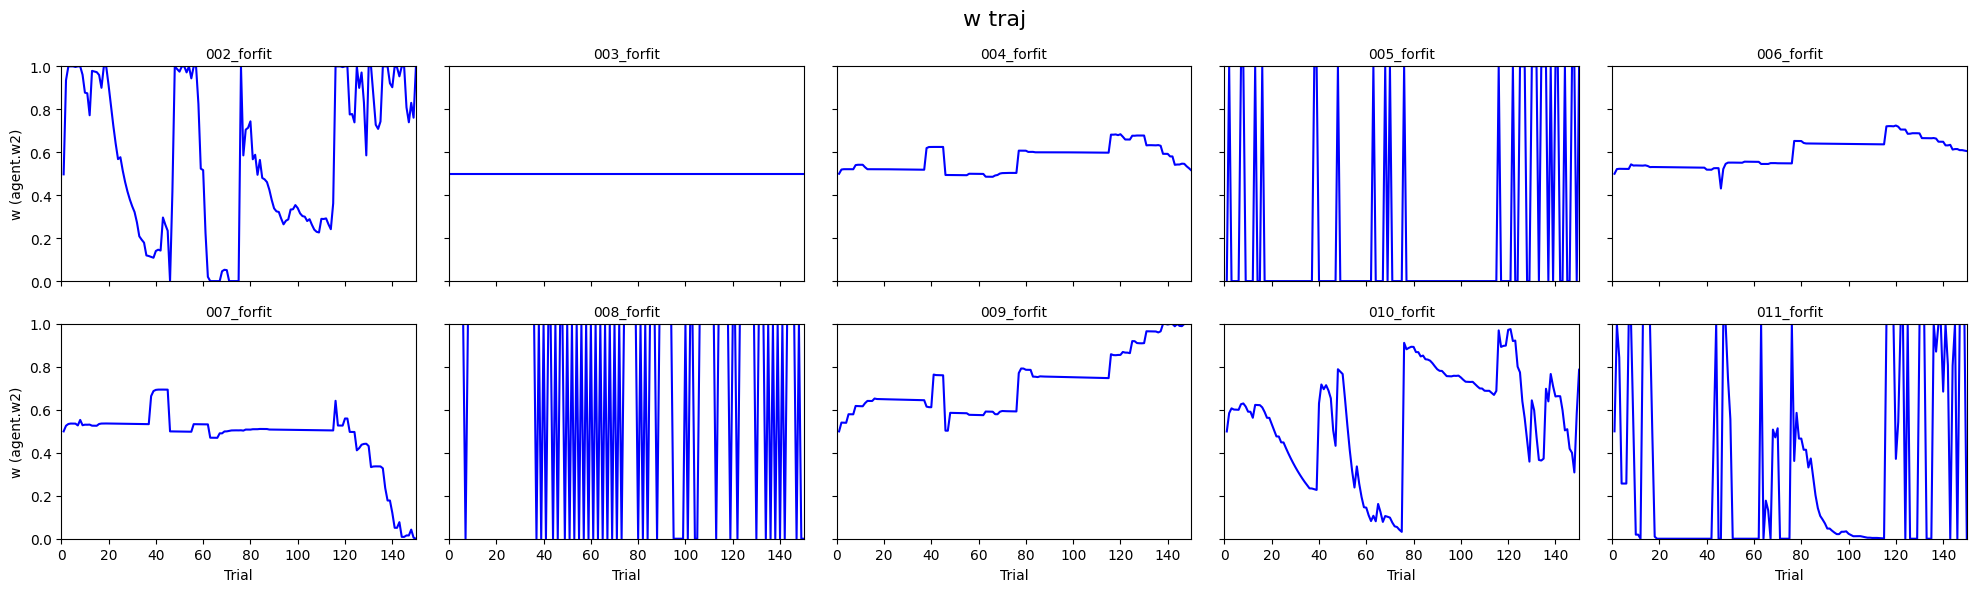

In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import loss4arbitration_fit as agent
from loss4arbitration_fit import two_stage


def sim(agent_fn, params, n_episode = 150, seed=873): 
    # agent_fn = larbi specific,high; flexible,low; specific, high; flexible, low
    cols = ['w']
    sim_data = {col: [] for col in cols}
    nS, nA= 9, 2 
    rng = np.random.RandomState(seed)
    agent = agent_fn(nS, nA, rng, params=params)
    env = two_stage()
    
    prev_goal = None
    
    certainty = 0
    goal = 2
    for epi in range(n_episode):
        
        # Block 1 0-36: fixed 20, uncertainty=0.9 
        # Block 2 37-74: flexible, uncertainty=0.9  
        # Block 3 75-111: fixed 10, uncertainty=0.5 
        # Block 4 112-149: flexible, uncertainty=0.5 
        
        if epi < 37: 
            goal = 2 
            certainty = 0  
        elif epi < 75:   
            goal = 0  
            certainty = 0  
        elif epi < 112:
            goal = 1  
            certainty = 1  
        else:  
            goal = 0  
            certainty = 1 
        
        
        # recompute MB values when task block changes(BACK PLANNING)
        if goal != prev_goal:
            agent.back_plan(goal)
            prev_goal = goal
            
        # stage 1
        s1 = env.reset()          # get state 
        a1 = rng.choice(nA, p=agent.make_move(s1))           # get action
        # stage 2
        s2, r1, done = env.step(a1,C=certainty,W=goal)  # get state; C is the uncertainty, W is the reward condition
        a2 = rng.choice(nA, p=agent.make_move(s2))           # get action 
        # stage 3
        s3, r2, done = env.step(a2,C=certainty,W=goal)      # get reward
        agent.learn(s1, a1, s2, r1, a2, s3, r2, goal)   
        # save
        sim_data['w'].append(agent.w2)
    
    
    return sim_data

# ========== 1. 读取数据 ==========
fit_path = './PKL_DATA/fitdata/fitresults_FIRST10_larbi_decay_w.pkl'
all_path = './PKL_DATA/ALL_SUBJECTS.pkl'

R = pickle.load(open(fit_path, 'rb'))   # 拟合结果
A = pickle.load(open(all_path, 'rb'))   # {sid: DataFrame}
sid_list = list(A.keys())               # 保持拟合时的被试顺序

# 判断是 list 还是 dict 存储的拟合结果
is_dict = isinstance(R, dict)

# ========== 2. 配置 ==========
n_subjects = min(10, len(sid_list))     # 前10个被试
n_episode  = 150                        # 模拟trial数

# 创建大图：2行5列
fig, axes = plt.subplots(2, 5, figsize=(20, 6), sharex=True, sharey=True)
axes = axes.flatten()

# ========== 3. 循环前10个被试 ==========
for i in range(n_subjects):
    sid = sid_list[i]
    # 获取最优参数
    theta_vec = R[sid]['param'] if is_dict else R[i]['param']
    pnames = agent.larbi_decay_w.p_name
    theta  = {k: float(v) for k, v in zip(pnames, theta_vec)}

    # 用该被试的最优参数跑sim
    sim_out = sim(agent.larbi_decay_w, theta, n_episode=n_episode, seed=873)
    w_traj = sim_out['w']

    # 画图
    axes[i].plot(range(1, n_episode+1), w_traj, color='blue')
    axes[i].set_title(f"{sid}", fontsize=10)
    axes[i].set_xlim(0, n_episode)
    axes[i].set_ylim(0, 1)
    if i % 5 == 0:
        axes[i].set_ylabel("w (agent.w2)")
    if i >= 5:
        axes[i].set_xlabel("Trial")

# 调整布局
fig.suptitle("w traj", fontsize=16)
plt.tight_layout()
plt.show()
